Import data for train/test

In [11]:
import numpy as np
x_train = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_train.npy')
x_test = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_test.npy')
y_train = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_train.npy')
y_test = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_test.npy')

Train test data

# Define a model for SER

In [12]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, InputLayer

In [13]:
input_size = (256, 256, 3)

In [14]:
model = Sequential([
    InputLayer(input_shape=input_size),
    #1st hidden layer
    Conv2D(16, (3, 3), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    #2nd hidden layer
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding="same"),
    MaxPool2D((2, 2)),
    # 3rd conv block
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    #ANN
    Flatten(),
    Dropout(0.2),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    #Output layer
    Dense(units= 7, activation='softmax'),
]) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
15/15 [==============================] - 1s 33ms/step - loss: 1.9344 - accuracy: 0.2005 - val_loss: 1.8841 - val_accuracy: 0.2212
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 1.8597 - accuracy: 0.2434 - val_loss: 1.7439 - val_accuracy: 0.3451
Epoch 3/50
15/15 [==============================] - 0s 23ms/step - loss: 1.7529 - accuracy: 0.3541 - val_loss: 1.6533 - val_accuracy: 0.3717
Epoch 4/50
15/15 [==============================] - 0s 23ms/step - loss: 1.5436 - accuracy: 0.4228 - val_loss: 1.3292 - val_accuracy: 0.4602
Epoch 5/50
15/15 [==============================] - 0s 23ms/step - loss: 1.3291 - accuracy: 0.4966 - val_loss: 1.2333 - val_accuracy: 0.5752
Epoch 6/50
15/15 [==============================] - 0s 23ms/step - loss: 1.2796 - accuracy: 0.4922 - val_loss: 1.1919 - val_accuracy: 0.5575
Epoch 7/50
15/15 [==============================] - 0s 21ms/step - loss: 1.2875 - accuracy: 0.4870 - val_loss: 1.3255 - val_accuracy: 0.5575
Epoch 8/50
15

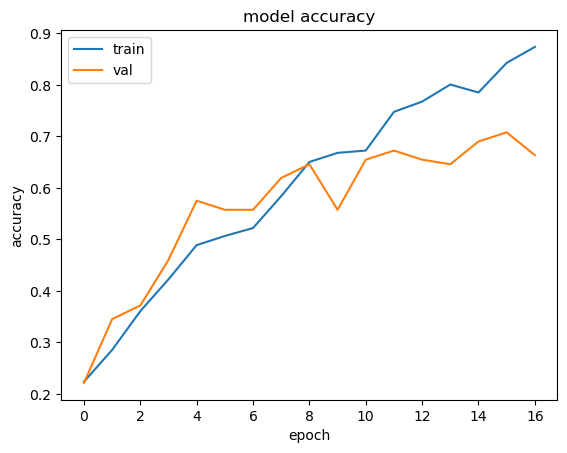

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

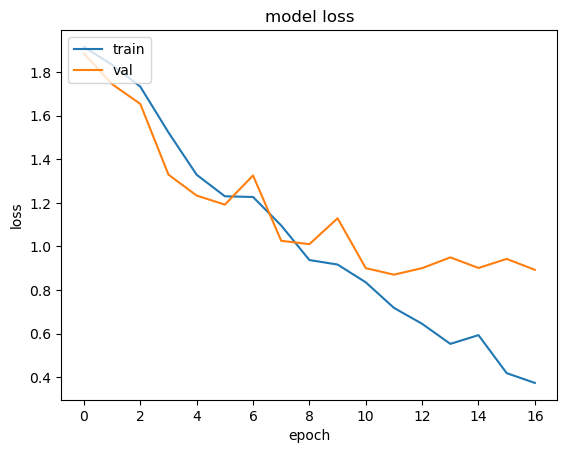

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

4/4 [==============================] - 0s 9ms/step - loss: 0.8709 - accuracy: 0.6726
Accuracy on original test data: 67.26%


Save the model for future computations

In [20]:
model.save('/datasets/nicolas_facchinetti/trained_models/EmoDB/firstCNN.h5')